#### Requirement of the notebook
<font color='red'>To run this notebook, you will have to create an anaconda environment with python==3.6 and R, install the packages 'mvtnorm' and 'condMVNorm' in R and 'rpy2==2.9.4' in Python. </font> 

# 3.2 Comparisons of the different estimators
## Reproduction of figures 4 and 5

In [4]:
import warnings
warnings.filterwarnings('ignore')

from acv_explainers import ACVTree
import shap

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import random 
import time 
import numpy as np
import pandas as pd
import seaborn as sns

random.seed(2021)
np.random.seed(2021)

from experiments.exp_linear import *

# Fixed the seed and plot env
random.seed(1)
np.random.seed(1)

plt.style.use(['ggplot'])

In [2]:
def bar_plot(values_1, values_2, values_3, values_4, labels):
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(dpi=250)
    rects1 = ax.bar(x - width/2, values_1, width, label='exact')
    rects2 = ax.bar(x + width/2, values_2, width, label='Monte_Carlo ')
    rects3 = ax.bar(x + 1.5*width, values_3, width, label='Plug-in ')
    rects4 = ax.bar(x + 2.5*width, values_4, width, label='SHAP')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Shapley values')
#     ax.set_title('Scores by group and gender')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', color='black')


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    fig.tight_layout()

    plt.show()
    

### Load data and model

In [3]:
p = 0.8
n = 10000
d = 3
cov = p*np.ones(shape=(d, d)) - (p - 1)*np.eye(d)
C = [[]]
b = np.random.randn(d, d)
cov = np.dot(b, b.T)

exp = ExperimentsLinear(mean=[0, 0, 0], cov=cov, coefs=[0.5, 10, -4], n=n, C=C)

In [4]:
seed = np.random.randint(0, 10000)
tree = DecisionTreeRegressor(min_samples_leaf=10, random_state=seed)
tree = exp.fit_model(tree)
seed

fitted model train_error = 0.9347550376675461
fitted model test_error = 1.547401474286805


2877

### Shapley values computation with the different algorithms (exact, shap, plugin, monte_carlo)

Exact - Elapsed time = 4.127213908999693
Plug-in - Elapsed time = 0.5512027370132273
Monte carlo - Elapsed timetime = 0.48772520800412167
Monte carlo - Elapsed timetime = 0.13940148000256158


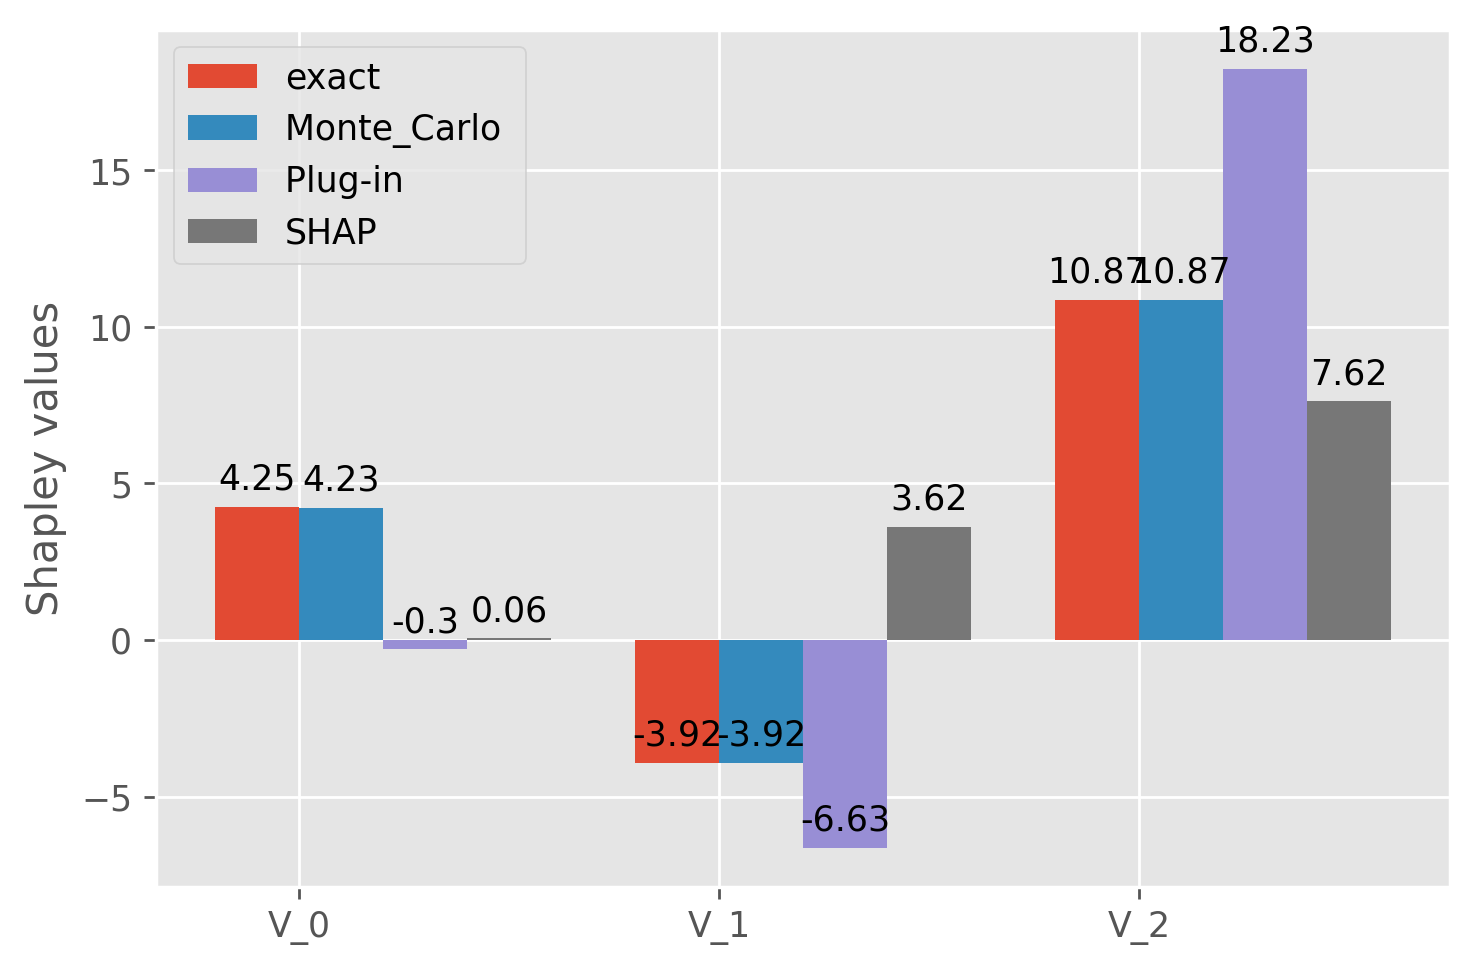

In [5]:
ind = exp.data[np.random.randint(0, n)]

t0 = time.perf_counter()
sh_e = exp.tree_shap(tree, ind, algo='exact')
# print(sh_e)
t1 = time.perf_counter()
print('Exact - Elapsed time = {}'.format(t1-t0))


t0 = time.perf_counter()
sh_o = exp.tree_shap(tree, ind, algo='plugin')
# print(sh_o)
t1 = time.perf_counter()
print('Plug-in - Elapsed time = {}'.format(t1-t0))

t0 = time.perf_counter()
sh_mc = exp.tree_shap(tree, ind, algo='monte_carlo', N=50000)
# print(sh_mc)
t1 = time.perf_counter()
print('Monte carlo - Elapsed timetime = {}'.format(t1-t0))

t0 = time.perf_counter()
sh_alg = exp.tree_shap(tree, ind, algo='shap', N=50000)
# print(sh_alg)
t1 = time.perf_counter()
print('Monte carlo - Elapsed timetime = {}'.format(t1-t0))

bar_plot(np.round(sh_e, 2), np.round(sh_mc, 2), np.round(sh_o, 2), np.round(sh_alg, 2),\
         ['V_{}'.format(i) for i in range(len(sh_e))])

In [6]:
print('x = {}'.format(ind))

x = [-2.53379431  0.3243397  -2.30089844]


100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


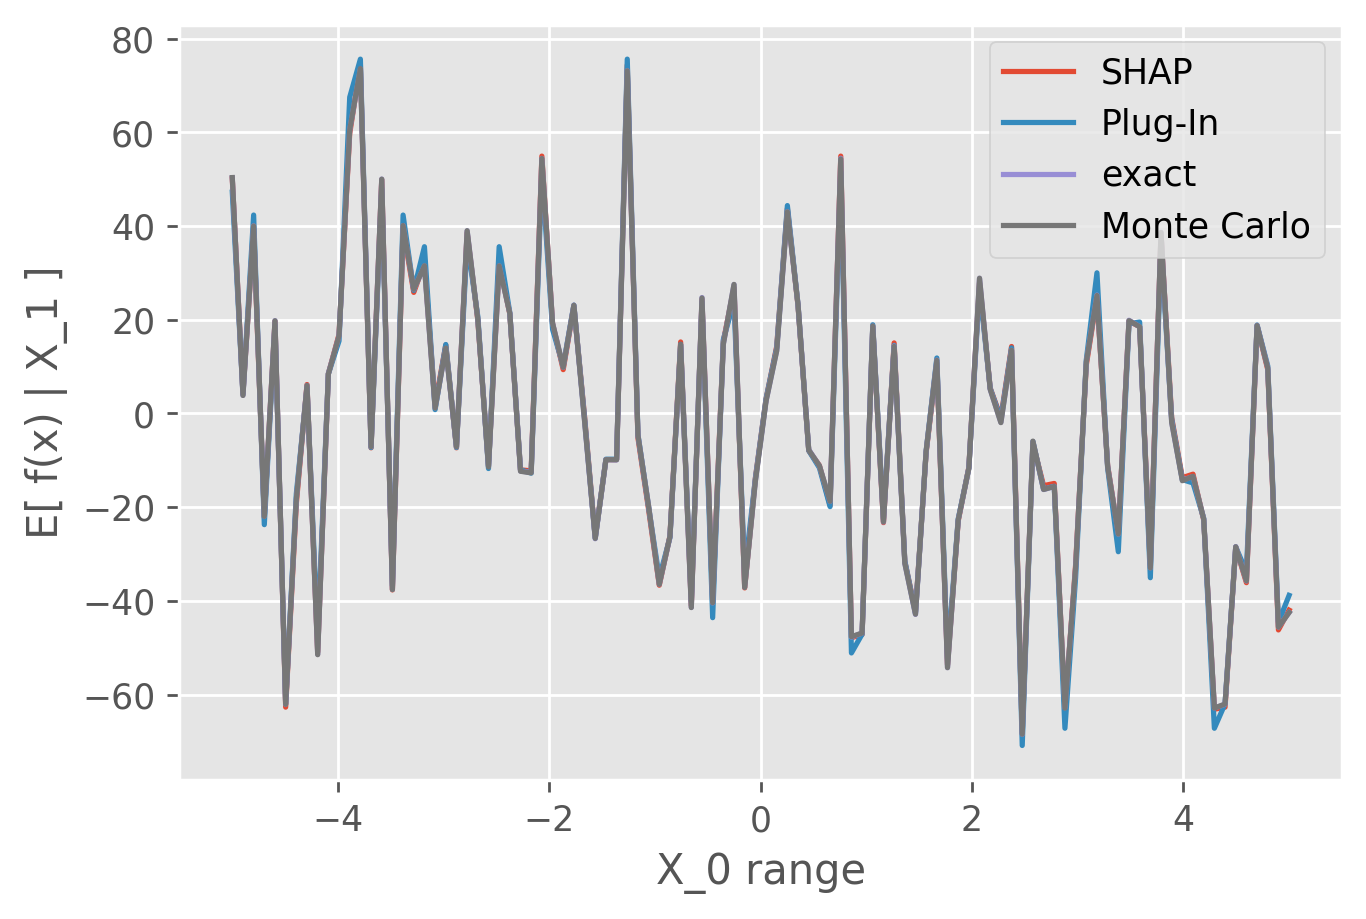

In [7]:
S = [1]
nb = 100
x_0 = np.linspace(-5, 5, nb)
sample = []
sample_lundb = []
sample_ours = []
sample_mc = []
sample_exact = []

for x in tqdm(x_0):
    a = sampleMVN(1, exp.mean, exp.cov, [1, 2], [0], x)
    sample.append(np.concatenate(([x], a[0])))    
   
    sample_lundb.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="shap"))
    sample_ours.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="plugin"))
    sample_mc.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="monte_carlo", N=n))
    sample_exact.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="exact"))
    
plt.figure(dpi=250)
plt.plot(x_0, sample_lundb, label='SHAP')
plt.plot(x_0, sample_ours, label='Plug-In')
plt.plot(x_0, sample_exact, label='exact')
plt.plot(x_0, sample_mc, label='Monte Carlo')
plt.ylabel('E[ f(x) | X_1 ]')
plt.xlabel('X_0 range')
plt.legend()

100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


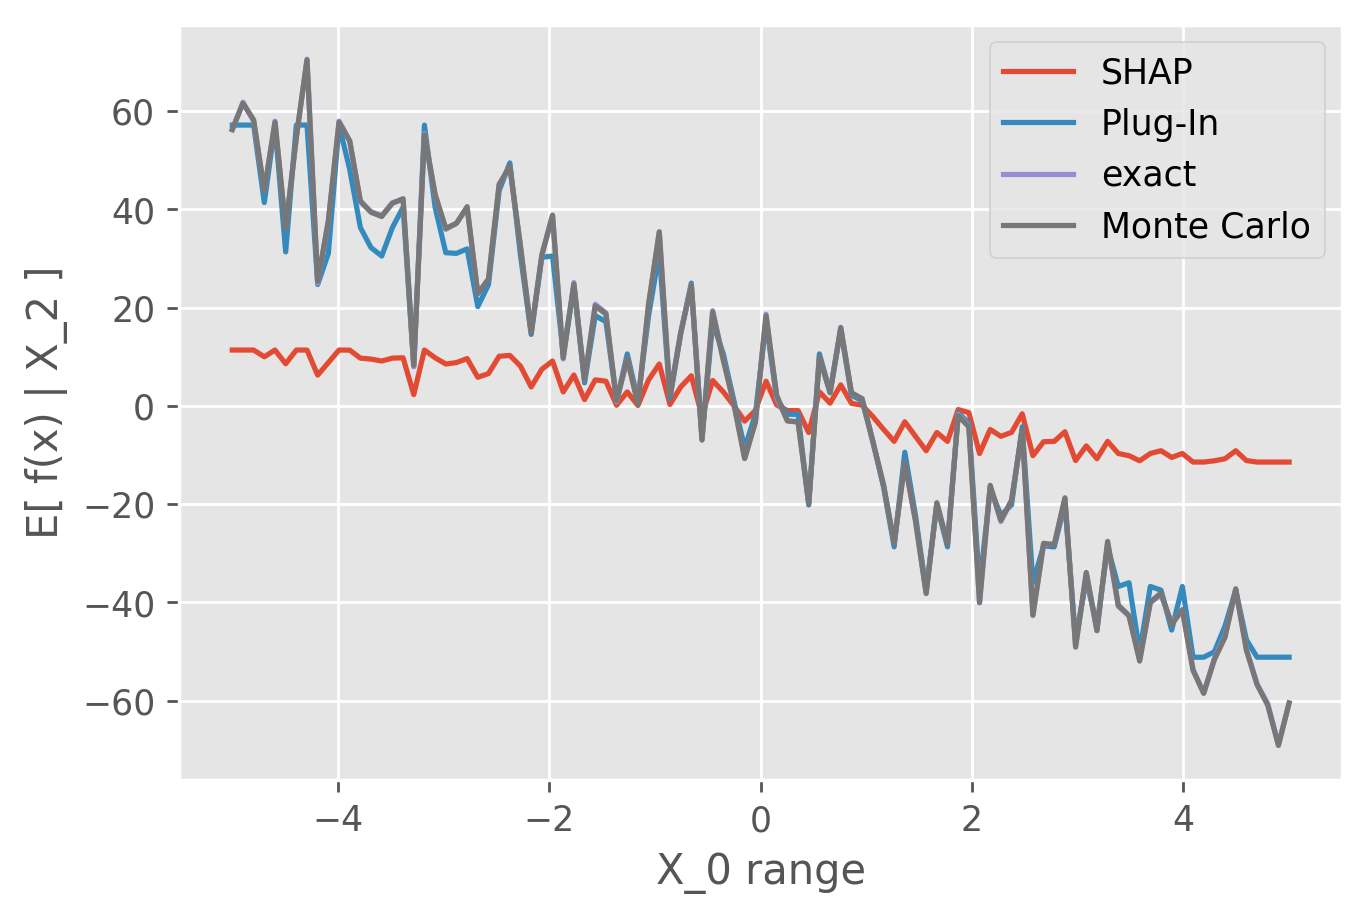

In [8]:
S = [2]
nb = 100
x_0 = np.linspace(-5, 5, nb)
sample = []
sample_lundb = []
sample_ours = []
sample_mc = []
sample_exact = []

for x in tqdm(x_0):
    a = sampleMVN(1, exp.mean, exp.cov, [1, 2], [0], x)
    sample.append(np.concatenate(([x], a[0])))    
   
    sample_lundb.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="shap"))
    sample_ours.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="plugin"))
    sample_mc.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="monte_carlo", N=n))
    sample_exact.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="exact"))
    
plt.figure(dpi=250)
plt.plot(x_0, sample_lundb, label='SHAP')
plt.plot(x_0, sample_ours, label='Plug-In')
plt.plot(x_0, sample_exact, label='exact')
plt.plot(x_0, sample_mc, label='Monte Carlo')
plt.ylabel('E[ f(x) | X_2 ]')
plt.xlabel('X_0 range')
plt.legend()

### Figure 4: Estimation of expectation $\mathbb{E} \left[ f(\boldsymbol{X}) | X_2 \right]$ with different observation and $X_0 \in \left[-4, 4\right]$.

100%|██████████| 100/100 [00:02<00:00, 34.16it/s]


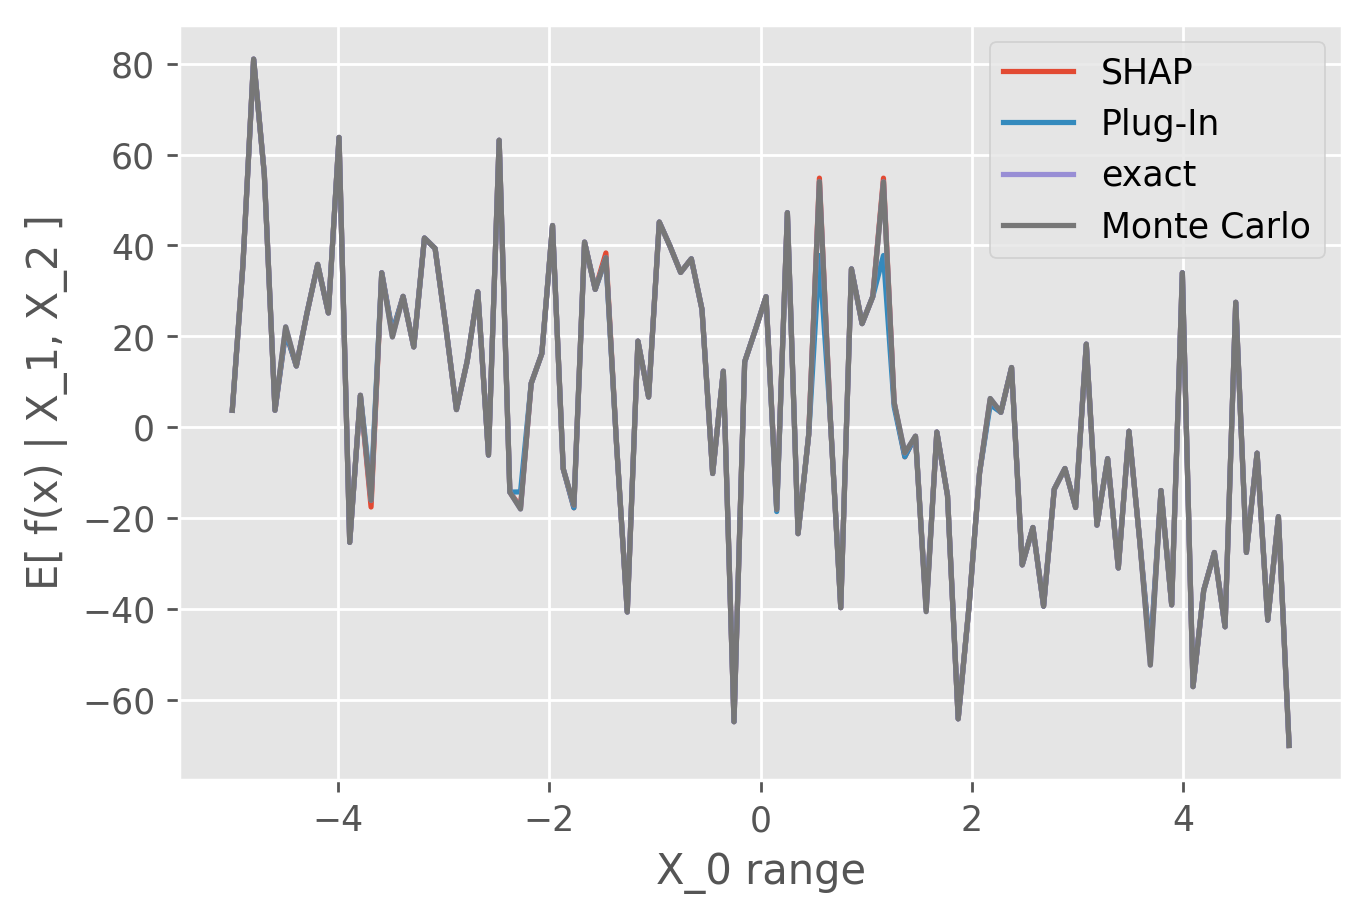

In [9]:
S = [1, 2]
nb = 100
x_0 = np.linspace(-5, 5, nb)
sample = []
sample_lundb = []
sample_ours = []
sample_mc = []
sample_exact = []

for x in tqdm(x_0):
    a = sampleMVN(1, exp.mean, exp.cov, [1, 2], [0], x)
    sample.append(np.concatenate(([x], a[0])))    
   
    sample_lundb.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="shap"))
    sample_ours.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="plugin"))
    sample_mc.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="monte_carlo", N=n))
    sample_exact.append(exp.cond_exp_tree(x=sample[-1], tree=tree.tree_, S=S, algo="exact"))
    
plt.figure(dpi=250)
plt.plot(x_0, sample_lundb, label='SHAP')
plt.plot(x_0, sample_ours, label='Plug-In')
plt.plot(x_0, sample_exact, label='exact')
plt.plot(x_0, sample_mc, label='Monte Carlo')
plt.ylabel('E[ f(x) | X_1, X_2 ]')
plt.xlabel('X_0 range')
plt.legend()

### Errors distribution of Shapley values between the exact and the different estimators

100%|██████████| 200/200 [19:06<00:00,  5.73s/it]


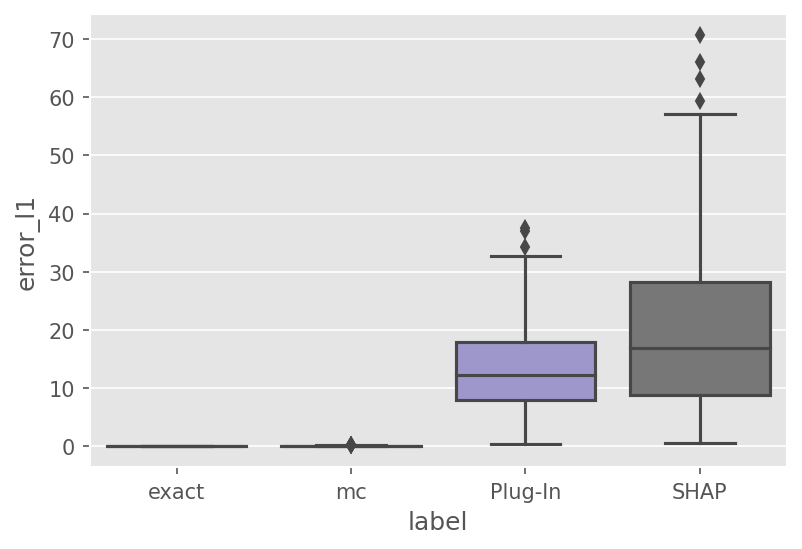

In [10]:
data_shap = exp.shap_fit_metric(tree, exp.data_test, nb=200, plot=True)

### Figure 5: Errors distribution between the true SV with exact expectation and the corresponding algorithm (SHAP, Plug-In, MC) over 200 new observations generated by $P_{\boldsymbol{X}}$.